# Temporal Convolutional Network

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My Drive/Pump Data/

/content/gdrive/My Drive/Pump Data


In [3]:
!ls

allpumps_tcn_v1.pth.tar  __pycache__		test_results.csv
data			 tcn_valid_results.csv	utils.py


In [4]:
!pip install matplotlib==3.1.3
!pip install darts

     |████████████████████████████████| 13.1 MB 4.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 286 kB 5.2 MB/s 
     |████████████████████████████████| 11.3 MB 61.2 MB/s 
     |████████████████████████████████| 790 kB 66.8 MB/s 
     |████████████████████████████████| 65 kB 5.6 MB/s 
     |████████████████████████████████| 38.2 MB 1.2 MB/s 
     |████████████████████████████████| 155 kB 59.9 MB/s 
     |████████████████████████████████| 11.2 MB 60.3 MB/s 
     |████████████████████████████████| 1.4 MB 57.5 MB/s 
     |████████████████████████████████| 2.0 MB 52.8 MB/s 
     |████████████████████████████████| 62 kB 992 kB/s 
     |████████████████████████████████| 9.8 MB 25.6 MB/s 
     |████████████████████████████████| 177 kB 74.7 MB/s 
     |████████████████████████████████| 374 kB 60.8 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
     |████████████████████████████████| 214 kB 75.8 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=4a2f6cfd1ac271bdf57f3538da98b86eb5674d5cafa25

In [5]:
EPOCH = 100


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta, TCNModel
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf, plot_hist
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


FC_N = 12               # forecast periods
FC_STRIDE = 10
FC_START = '2019-07-25 00:00:00'   # period at which to split training and validation dataset
DROP = 0.1
LEARN = 0.001

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

In [8]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper


In [9]:
data_address = 'data'
training = pd.read_csv(data_address +'/cfp_dataset_v1.csv', index_col=False)
training.drop(['Unnamed: 0', 'MIDUPT1138P2300058', 'SHORTUPT1138P2300058', 'LONGUPT1138P2300058', 'DMIDT1138P2300058',  'DLONGT1138P2300058', 'UNIXDT', 'UUID'], axis=1, inplace=True)

In [10]:
training.columns

Index(['WELL_ID', 'DT', 'T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399',
       'DSHORTT1138P2300058'],
      dtype='object')

In [11]:
only_1_bad = training[training['WELL_ID'] == 226003316].copy()


In [12]:
only_1_bad.DT

9990     2019-07-31 23:55:00
9991     2019-07-31 23:50:00
9992     2019-07-31 23:45:00
9993     2019-07-31 23:40:00
9994     2019-07-31 23:35:00
                ...         
19972    2019-06-27 07:00:00
19973    2019-06-27 06:55:00
19974    2019-06-27 06:50:00
19975    2019-06-27 06:45:00
19976    2019-06-27 06:40:00
Name: DT, Length: 9987, dtype: object

## подготовим данные для всех насосов

In [13]:
from sklearn.preprocessing import LabelBinarizer

pump_encoder = LabelBinarizer()
transformed = pump_encoder.fit_transform(training.WELL_ID)
ohe_df = pd.DataFrame(transformed)
ohe_df.columns = pump_encoder.classes_
training_oh = pd.concat([training, ohe_df], axis=1).drop(['WELL_ID'], axis=1)
training_oh

DT  T1138P6000096  ...  226003316  226003330
0       2019-07-31 23:55:00            300  ...          0          1
1       2019-07-31 23:50:00              0  ...          0          1
2       2019-07-31 23:45:00              0  ...          0          1
3       2019-07-31 23:40:00              0  ...          0          1
4       2019-07-31 23:35:00              0  ...          0          1
...                     ...            ...  ...        ...        ...
160257  2019-06-27 07:00:00              0  ...          0          0
160258  2019-06-27 06:55:00              0  ...          0          0
160259  2019-06-27 06:50:00              0  ...          0          0
160260  2019-06-27 06:45:00              0  ...          0          0
160261  2019-06-27 06:40:00              0  ...          0          0

[160262 rows x 35 columns]

реализовать нарезку на train-test


In [14]:
def get_pump_names(df):
  """
  вытаскиваем set из колонок по df, который подали
  """
  values = df.columns
  return set(values)


def split_df_by_pumps(input_df, ohe_df):
  """
  input_df: дф, в котором есть колонки onehot с насовами
  ohe_df: дф onehot для насосов
  выдает 17 штук train set
  """

  pump_ids = get_pump_names(ohe_df)
  df_list = list()

  for pump in pump_ids:
    df_list.append(input_df[input_df[pump] == 1])

  return df_list



реализовать нарезку на файлы по названию насосов

find when to split?

In [15]:
only_1_bad['DT'] = pd.to_datetime(only_1_bad['DT'] )

print(only_1_bad.DT.min()-
      only_1_bad.DT.max())

only_1_bad.DT.min() + (only_1_bad.DT.max() - only_1_bad.DT.min()) * 0.8

-35 days +06:45:00


Timestamp('2019-07-25 01:16:00')

In [16]:
series = TimeSeries.from_dataframe(only_1_bad, 'DT', fill_missing_dates=True, freq=None)


In [17]:
scaler = Scaler()
ts = scaler.fit_transform(series)  # scale the whole time series not caring about train/val split...
filler = MissingValuesFiller()
ts = filler.transform(ts, method='quadratic')
target = ts['DSHORTT1138P2300058']
# Create training and validation sets:
train_target, val_target = target.split_after(pd.Timestamp(FC_START))

covariates = ts[['WELL_ID', 'T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399']]

train_cov, val_cov = covariates.split_after(pd.Timestamp(FC_START))
train_1cov, val_1cov = covariates['T1138P600050'].split_after(pd.Timestamp(FC_START))

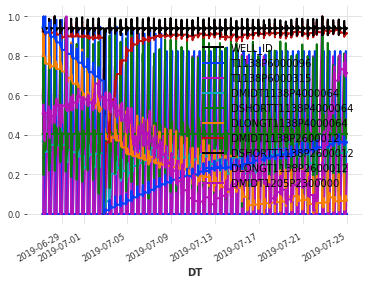

In [18]:
train_cov.plot()

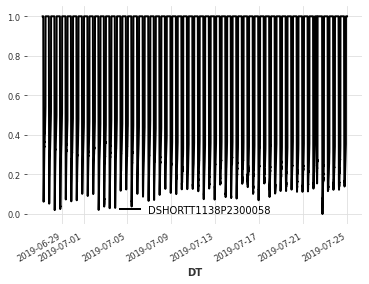

In [19]:
train_target.plot()

In [20]:
train_1cov.freq

<5 * Minutes>

In [21]:
train_1cov.pd_dataframe()

component            T1138P600050
DT                               
2019-06-27 06:40:00           0.0
2019-06-27 06:45:00           0.0
2019-06-27 06:50:00           0.0
2019-06-27 06:55:00           0.0
2019-06-27 07:00:00           0.0
...                           ...
2019-07-24 23:40:00           0.0
2019-07-24 23:45:00           0.0
2019-07-24 23:50:00           0.0
2019-07-24 23:55:00           0.0
2019-07-25 00:00:00           0.0

[7985 rows x 1 columns]

In [22]:
train_target.describe()


component  DSHORTT1138P2300058
count              7985.000000
mean                  0.748431
std                   0.356740
min                   0.000000
25%                   0.322829
50%                   1.000000
75%                   1.000000
max                   1.000000

In [23]:
train_target

<TimeSeries (DataArray) (DT: 7985, component: 1, sample: 1)>
array([[[1.]],

       [[1.]],

       [[1.]],

       ...,

       [[1.]],

       [[1.]],

       [[1.]]])
Coordinates:
  * DT         (DT) datetime64[ns] 2019-06-27T06:40:00 ... 2019-07-25
  * component  (component) object 'DSHORTT1138P2300058'
Dimensions without coordinates: sample

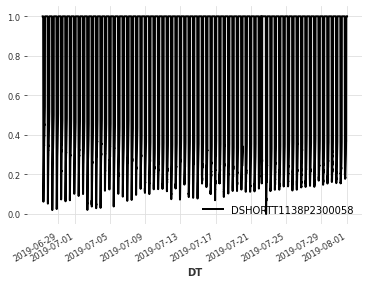

In [24]:
target.plot()

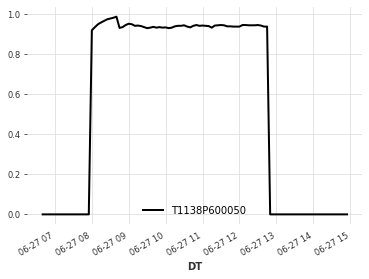

In [25]:
train_1cov[:100].plot()

In [26]:
# analyze its seasonality

is_seasonal, periodicity = check_seasonality(target, max_lag=1000)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (5*minutes)":f'{periodicity:.1f}', 
    "periodicity (hours)":f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (5*minutes) : 144.0
periodicity (hours) : 12.0


In [27]:
import statsmodels.api as sm

<AxesSubplot:xlabel='DT'>

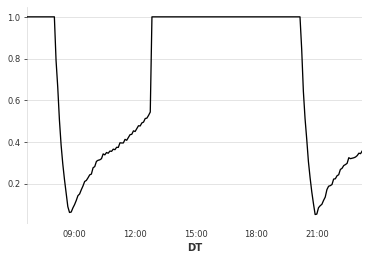

In [28]:
target.pd_dataframe().DSHORTT1138P2300058[:200].plot()

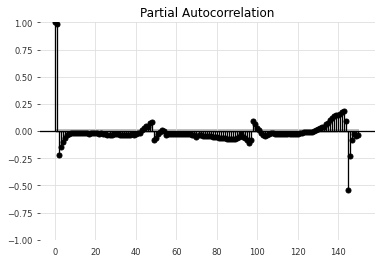

In [29]:
sm.graphics.tsa.plot_pacf(target.pd_dataframe().DSHORTT1138P2300058, lags=150)
plt.show()

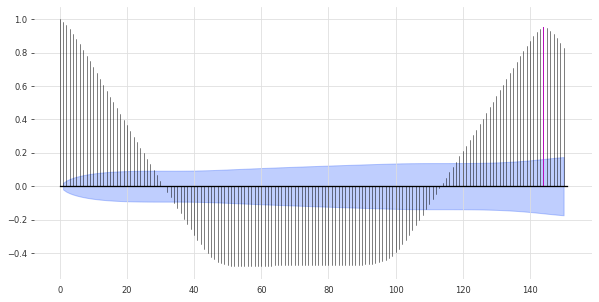

In [30]:
plot_acf(target, periodicity, max_lag=150)


In [31]:
target.describe()

component  DSHORTT1138P2300058
count             10000.000000
mean                  0.750620
std                   0.355972
min                   0.000000
25%                   0.319466
50%                   1.000000
75%                   1.000000
max                   1.000000

In [32]:
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape, mae


# lets do a simple one

In [33]:
one_var = covariates['T1205P2300000'].copy()

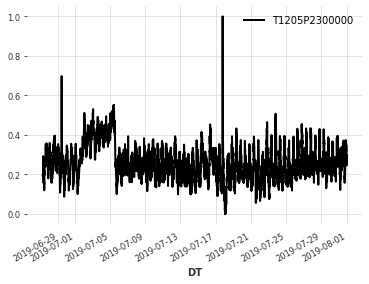

In [34]:
one_var.plot()

In [35]:
train_cov1, val_cov1 = one_var.split_after(pd.Timestamp('2019-07-25 00:00:00'))

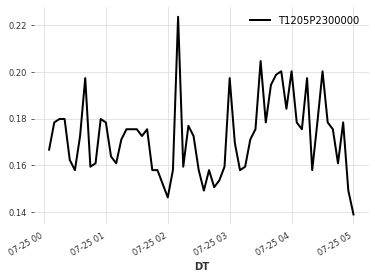

In [36]:
val_cov1[:60].plot()

In [37]:
val_cov1.time_index

DatetimeIndex(['2019-07-25 00:05:00', '2019-07-25 00:10:00',
               '2019-07-25 00:15:00', '2019-07-25 00:20:00',
               '2019-07-25 00:25:00', '2019-07-25 00:30:00',
               '2019-07-25 00:35:00', '2019-07-25 00:40:00',
               '2019-07-25 00:45:00', '2019-07-25 00:50:00',
               ...
               '2019-07-31 23:10:00', '2019-07-31 23:15:00',
               '2019-07-31 23:20:00', '2019-07-31 23:25:00',
               '2019-07-31 23:30:00', '2019-07-31 23:35:00',
               '2019-07-31 23:40:00', '2019-07-31 23:45:00',
               '2019-07-31 23:50:00', '2019-07-31 23:55:00'],
              dtype='datetime64[ns]', name='DT', length=2015, freq='5T')

In [38]:
model_1var = TCNModel(
    input_chunk_length=24,
    output_chunk_length=2,
    n_epochs=EPOCH,
    dropout=0.01,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

In [39]:
model_1var.fit(series=train_target,
              past_covariates=train_cov1,
              val_series=val_target,
              val_past_covariates=val_cov1,
              verbose=True)

  1%|          | 1/100 [00:04<07:53,  4.78s/it]

 11%|█         | 11/100 [00:42<05:52,  3.96s/it]

 21%|██        | 21/100 [01:20<05:14,  3.98s/it]

 31%|███       | 31/100 [01:58<04:31,  3.94s/it]

 41%|████      | 41/100 [02:36<03:53,  3.96s/it]

 51%|█████     | 51/100 [03:15<03:14,  3.97s/it]

 61%|██████    | 61/100 [03:53<02:34,  3.96s/it]

 71%|███████   | 71/100 [04:31<01:55,  3.97s/it]

 81%|████████  | 81/100 [05:09<01:15,  4.00s/it]

 91%|█████████ | 91/100 [05:47<00:35,  3.95s/it]

100%|██████████| 100/100 [06:20<00:00,  3.81s/it]


In [40]:
backtest_1var = model_1var.historical_forecasts(series=val_target,
                                                past_covariates=val_cov1, start=0.1,
                                            retrain=False,
                                            verbose=True)


100%|██████████| 1814/1814 [00:12<00:00, 139.94it/s]


In [41]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


In [42]:
val_target_inters = val_target.slice_intersect(backtest_1var)

MAPE = 0.05%
MAE = 0.02
smape = 0.05%
R2 = 0.95%


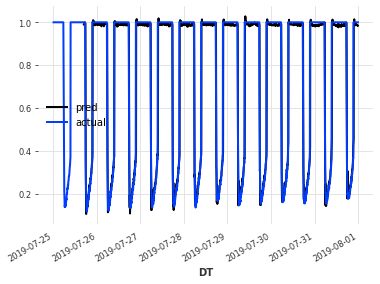

In [43]:
backtest_1var.plot(label='pred')
val_target.plot(label='actual')
plt.legend();
print('MAPE = {:.2f}%'.format(mean_absolute_percentage_error(val_target_inters.values(), backtest_1var.values())))
print('MAE = {:.2f}'.format(mae(val_target_inters, backtest_1var)))
print('smape = {:.2f}%'.format(smape(val_target_inters.values(), backtest_1var.values())))
print('R2 = {:.2f}%'.format(r2_score(val_target_inters.values(), backtest_1var.values())))


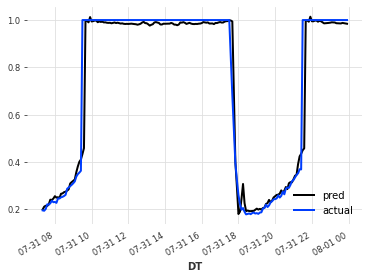

In [44]:
backtest_1var[-200:].plot(label='pred')
val_target[-200:].plot(label='actual')


## do with all covariates for 1 pump

In [45]:
model_1pump = TCNModel(
    input_chunk_length=144,
    output_chunk_length=1,
    n_epochs=EPOCH,
    dropout=0.01,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

In [46]:
model_1pump.fit(series=train_target,
              past_covariates=train_cov,
              val_series=val_target,
              val_past_covariates=val_cov,
              verbose=True)

  1%|          | 1/100 [00:05<09:01,  5.47s/it]

 11%|█         | 11/100 [00:52<07:12,  4.86s/it]

 21%|██        | 21/100 [01:39<06:24,  4.87s/it]

 31%|███       | 31/100 [02:26<05:34,  4.85s/it]

 41%|████      | 41/100 [03:12<04:45,  4.83s/it]

 51%|█████     | 51/100 [03:59<03:56,  4.83s/it]

 61%|██████    | 61/100 [04:46<03:08,  4.83s/it]

 71%|███████   | 71/100 [05:33<02:20,  4.86s/it]

 81%|████████  | 81/100 [06:19<01:32,  4.85s/it]

 91%|█████████ | 91/100 [07:06<00:43,  4.88s/it]

100%|██████████| 100/100 [07:48<00:00,  4.68s/it]


In [47]:
backtest_1pump = model_1pump.historical_forecasts(series=val_target,
                                                past_covariates=val_cov, start=0.1,
                                            retrain=False,
                                            verbose=True)


100%|██████████| 1814/1814 [00:14<00:00, 121.09it/s]


In [48]:
val_1pumptarget_inters = val_target.slice_intersect(backtest_1pump)

MAPE = 0.04%
MAE = 0.01
smape = 0.04%
R2 = 0.98%


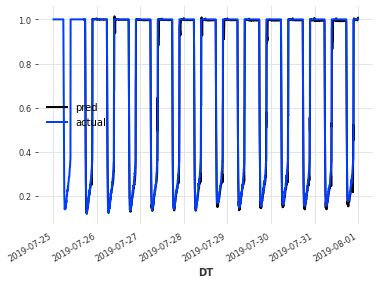

In [49]:
backtest_1pump.plot(label='pred')
val_target.plot(label='actual')
plt.legend();
print('MAPE = {:.2f}%'.format(mean_absolute_percentage_error(val_1pumptarget_inters.values(), backtest_1pump.values())))
print('MAE = {:.2f}'.format(mae(val_1pumptarget_inters, backtest_1pump)))
print('smape = {:.2f}%'.format(smape(val_1pumptarget_inters.values(), backtest_1pump.values())))
print('R2 = {:.2f}%'.format(r2_score(val_1pumptarget_inters.values(), backtest_1pump.values())))


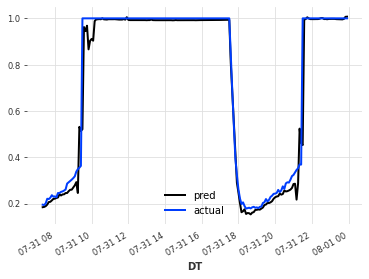

In [50]:
backtest_1pump[-200:].plot(label='pred')
val_target[-200:].plot(label='actual')

## сделаем теперь обучение на множестве временных рядов

In [51]:
all_pumps_df = split_df_by_pumps(training_oh, ohe_df)

In [52]:
all_pumps_df[0].head()

DT  T1138P6000096  ...  226003316  226003330
29577  2019-07-31 23:55:00              0  ...          0          0
29578  2019-07-31 23:50:00              0  ...          0          0
29579  2019-07-31 23:45:00              0  ...          0          0
29580  2019-07-31 23:40:00              0  ...          0          0
29581  2019-07-31 23:35:00              0  ...          0          0

[5 rows x 35 columns]

In [53]:
FC_START

'2019-07-25 00:00:00'

In [54]:
def get_one_pump_train_date(inp_df):
  onehot_series_0 = TimeSeries.from_dataframe(inp_df, 'DT', fill_missing_dates=True, freq='5T')

  scaler = Scaler()
  ts = scaler.fit_transform(onehot_series_0)  # scale the whole time series not caring about train/val split...
  filler = MissingValuesFiller()
  ts = filler.transform(ts, method='linear')
  target = ts['DSHORTT1138P2300058']
  # Create training and validation sets:
  train_target, val_target = target.split_after(pd.Timestamp(FC_START))

  covariates = ts[['T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
        'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
        'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
        'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
        'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399']]

  train_cov, val_cov = covariates.split_after(pd.Timestamp(FC_START))
  print(len(train_cov), len(train_target), len(val_cov), len(val_target))
  return train_cov, train_target, val_cov, val_target

def get_all_pump_training_date(df_all_pumps):
  train_cov_all, train_target_all, val_cov_all, val_target_all = [], [], [], []
  for pump_df in df_all_pumps:
    iter_train, iter_target, iter_val, iter_val_target = get_one_pump_train_date(pump_df)
    train_cov_all.append(iter_train)
    train_target_all.append(iter_target)
    val_cov_all.append(iter_val)
    val_target_all.append(iter_val_target)
  return train_cov_all, train_target_all, val_cov_all, val_target_all


In [55]:
train_cov_v3, train_target_v3, val_cov_v3, val_target_v3= get_all_pump_training_date(all_pumps_df)

7985 7985 2015 2015
7985 7985 2015 2015
1165 1165 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015


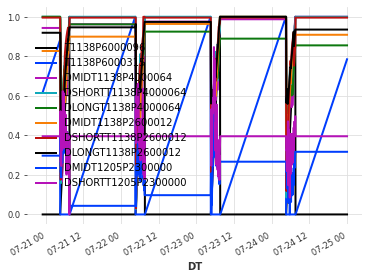

In [56]:
train_cov_v3[2].plot()

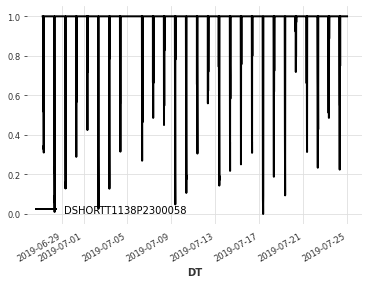

In [57]:
train_target_v3[1].plot()

In [58]:
model_all_pumps = TCNModel(
    input_chunk_length=144,
    output_chunk_length=1,
    n_epochs=EPOCH,
    dropout=0.01,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

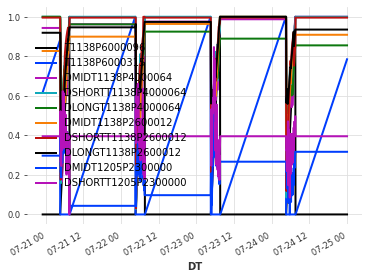

In [59]:
train_cov_v3[2].plot()

In [60]:
model_all_pumps.fit(series=train_target_v3,
              past_covariates=train_cov_v3,
              val_series=val_target_v3,
              val_past_covariates=val_cov_v3,
              verbose=True)

  1%|          | 1/100 [01:31<2:30:56, 91.48s/it]

 11%|█         | 11/100 [14:47<2:02:11, 82.38s/it]

 21%|██        | 21/100 [27:59<1:47:43, 81.82s/it]

 31%|███       | 31/100 [41:10<1:34:07, 81.85s/it]

 41%|████      | 41/100 [54:22<1:20:33, 81.92s/it]

 51%|█████     | 51/100 [1:07:34<1:06:50, 81.85s/it]

 61%|██████    | 61/100 [1:20:43<53:05, 81.67s/it]

 71%|███████   | 71/100 [1:33:51<39:28, 81.66s/it]

 81%|████████  | 81/100 [1:46:58<25:47, 81.43s/it]

 91%|█████████ | 91/100 [2:00:07<12:16, 81.84s/it]

100%|██████████| 100/100 [2:11:46<00:00, 79.06s/it]


In [61]:
model_all_pumps.save_model('allpumps_tcn_v1.pth.tar')

In [62]:
backtest_model_all_pumps = model_all_pumps.historical_forecasts(series=val_target_v3[0],
                                                past_covariates=val_cov_v3[0], start=0.1,
                                            retrain=False,
                                            verbose=True)


100%|██████████| 1814/1814 [00:14<00:00, 122.28it/s]


In [63]:
backtest_v3 = val_target_v3[0]
val_v3pumptarget_inters = backtest_v3.slice_intersect(backtest_model_all_pumps)


MAPE = 0.99%
MAE = 0.01
smape = 0.99%
R2 = 99.18%


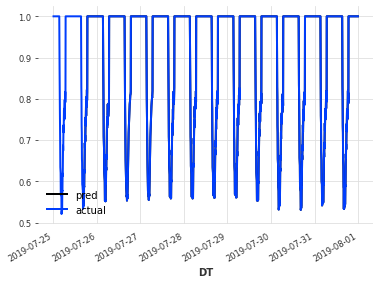

In [64]:
val_v3pumptarget_inters.plot(label='pred')
val_target_v3[0].plot(label='actual')
plt.legend();
print('MAPE = {:.2f}%'.format(mean_absolute_percentage_error(val_v3pumptarget_inters.values(), backtest_model_all_pumps.values())*100))
print('MAE = {:.2f}'.format(mae(val_v3pumptarget_inters, backtest_model_all_pumps)))
print('smape = {:.2f}%'.format(smape(val_v3pumptarget_inters.values(), backtest_model_all_pumps.values())*100))
print('R2 = {:.2f}%'.format(r2_score(val_v3pumptarget_inters.values(), backtest_model_all_pumps.values())*100))


сделаем процедуру для запуска по всем насосам валидации

In [65]:
get_pump_names(ohe_df)


{226000188,
 226000198,
 226000297,
 226001846,
 226001947,
 226002142,
 226002148,
 226002307,
 226002416,
 226002603,
 226002627,
 226002861,
 226002998,
 226003074,
 226003080,
 226003316,
 226003330}

In [66]:
def score_model_darts(model, validation_target, validation_cov, pump_names):
    results = pd.DataFrame(columns=['mape', 'smape', 'mae', 'r2_value'])
    pump_num = 0
    true_values = []
    predict_values = []
    for key in pump_names:
        backtest_model_all_pumps_iter = model_all_pumps.historical_forecasts(
            series=validation_target[pump_num],
            past_covariates=validation_cov[pump_num],
            start=0.1,
            retrain=False,
            verbose=True)

        backtest_v3 = validation_target[pump_num]
        val_v3pumptarget_inters = backtest_v3.slice_intersect(backtest_model_all_pumps_iter)

        

        y_true = val_v3pumptarget_inters.values()
        y_pred = backtest_model_all_pumps_iter.values()

        true_values.append(y_true)
        predict_values.append(y_pred)


        mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
        smape_v = smape(y_true, y_pred)
        mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
        r2_value = r2_score(y_true=y_true, y_pred=y_pred)

        this_key_df = pd.DataFrame({'mape': mape, 'smape': smape_v, 'mae': mae, 'r2_value': r2_value}, index=[key])
        results = results.append(this_key_df)

        val_v3pumptarget_inters[-100:].plot(label='pred')
        backtest_model_all_pumps_iter[-100:].plot(label='actual')
        plt.show()
        val_v3pumptarget_inters[:1000].plot(label='pred_first1k')
        backtest_model_all_pumps_iter[:1000].plot(label='actual_first1k')
        plt.show()
        pump_num += 1

    true_values = np.concatenate(true_values)
    predict_values = np.concatenate(predict_values)
    return results, true_values, predict_values


100%|██████████| 1814/1814 [00:14<00:00, 122.81it/s]


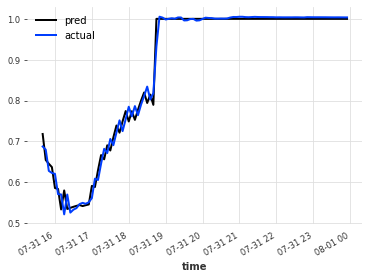

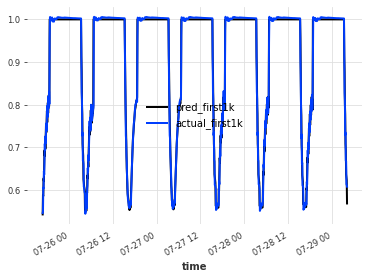

100%|██████████| 1814/1814 [00:14<00:00, 123.21it/s]


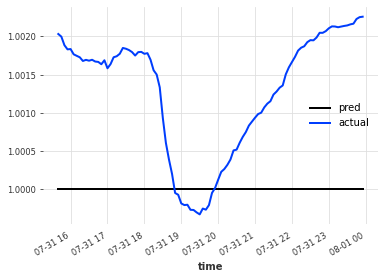

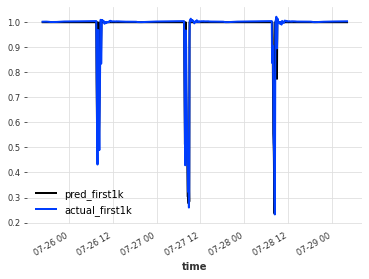

100%|██████████| 1814/1814 [00:14<00:00, 122.93it/s]


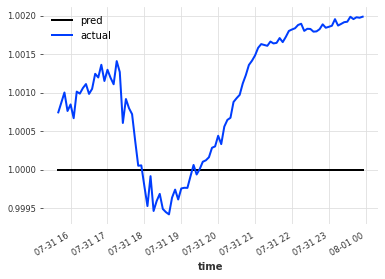

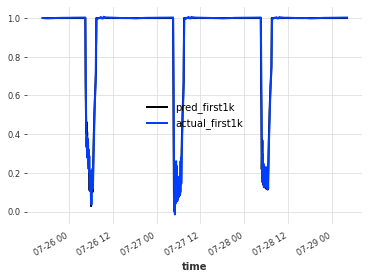

100%|██████████| 1814/1814 [00:14<00:00, 120.95it/s]


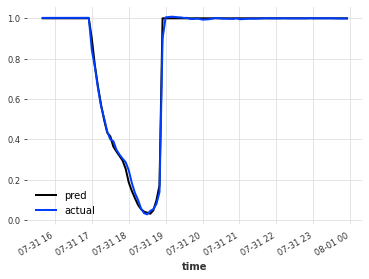

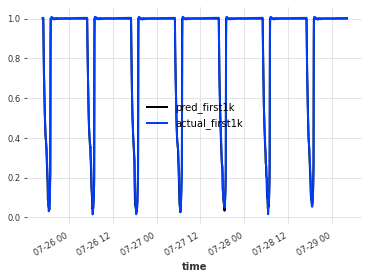

100%|██████████| 1814/1814 [00:15<00:00, 120.88it/s]


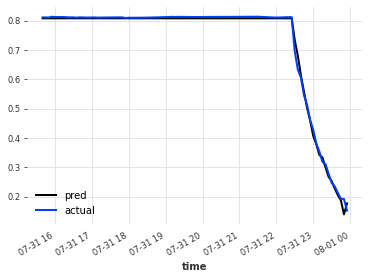

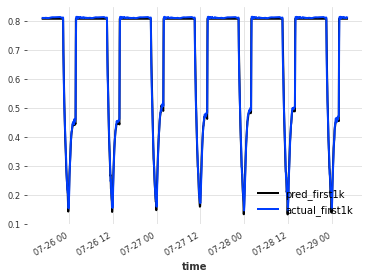

100%|██████████| 1814/1814 [00:15<00:00, 119.33it/s]


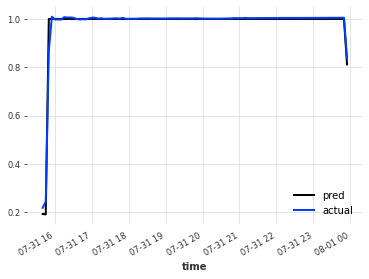

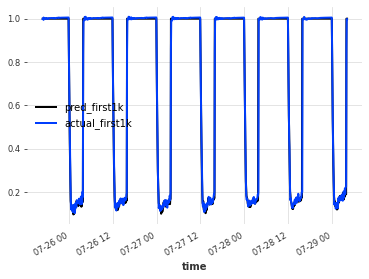

100%|██████████| 1814/1814 [00:15<00:00, 119.57it/s]


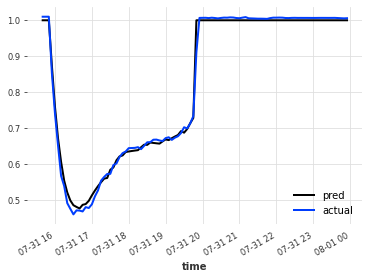

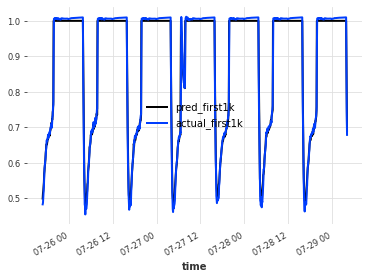

100%|██████████| 1814/1814 [00:15<00:00, 118.92it/s]


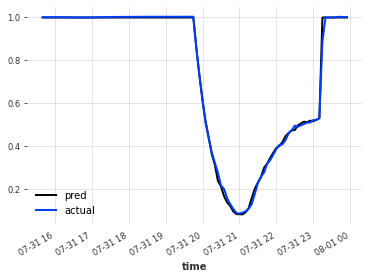

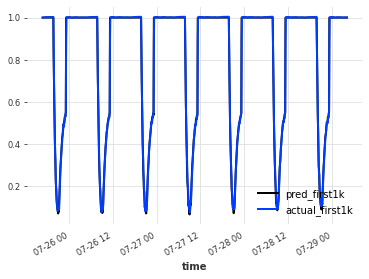

100%|██████████| 1814/1814 [00:15<00:00, 120.32it/s]


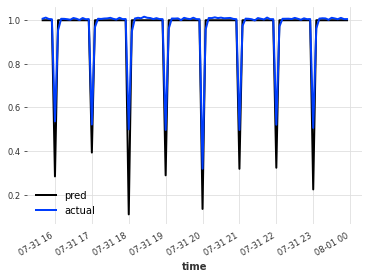

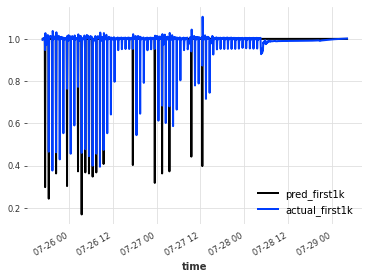

100%|██████████| 1814/1814 [00:15<00:00, 118.83it/s]


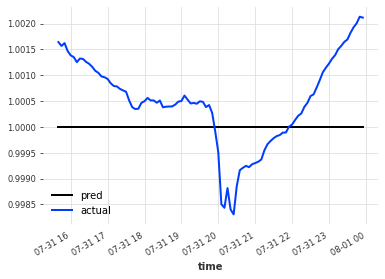

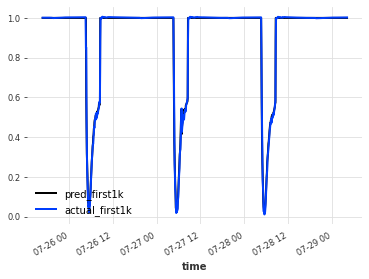

100%|██████████| 1814/1814 [00:15<00:00, 118.97it/s]


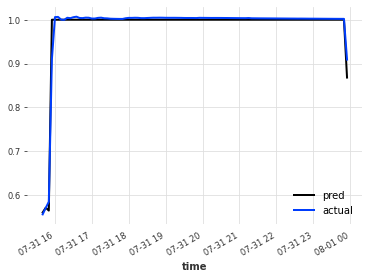

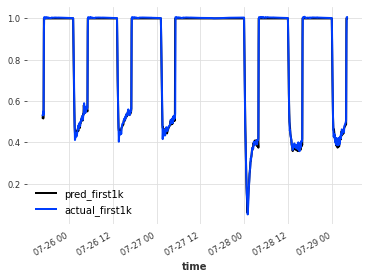

100%|██████████| 1814/1814 [00:15<00:00, 119.82it/s]


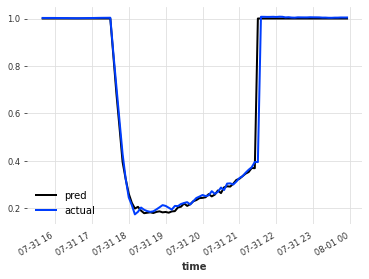

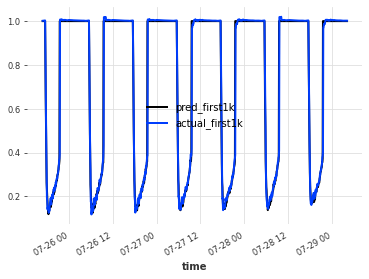

100%|██████████| 1814/1814 [00:15<00:00, 118.98it/s]


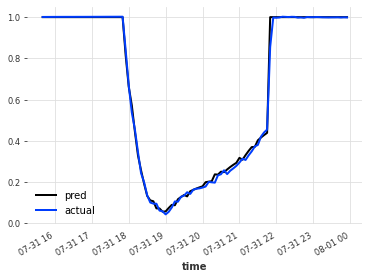

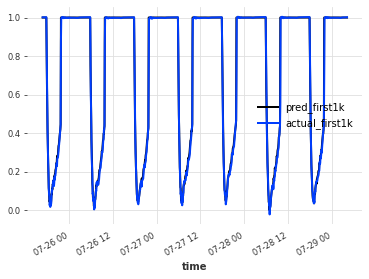

100%|██████████| 1814/1814 [00:15<00:00, 117.81it/s]


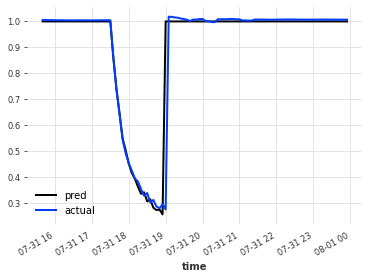

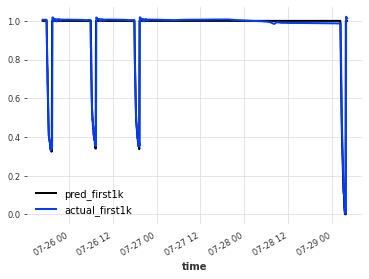

100%|██████████| 1814/1814 [00:15<00:00, 117.53it/s]


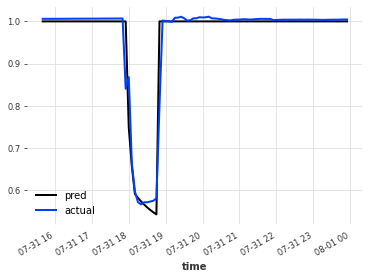

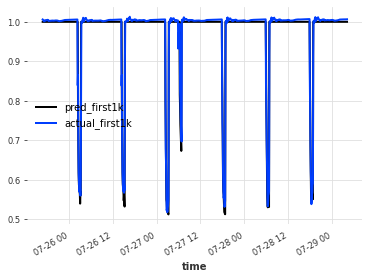

100%|██████████| 1814/1814 [00:15<00:00, 117.54it/s]


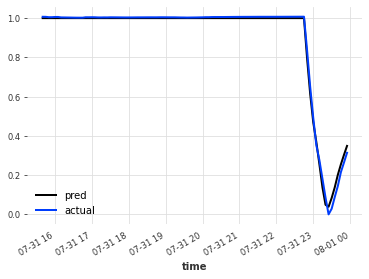

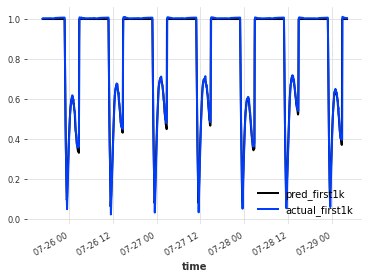

100%|██████████| 1814/1814 [00:15<00:00, 118.47it/s]


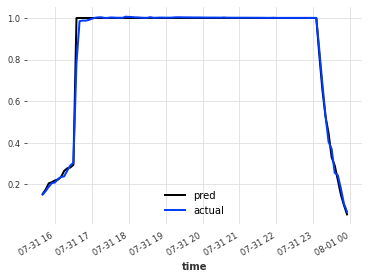

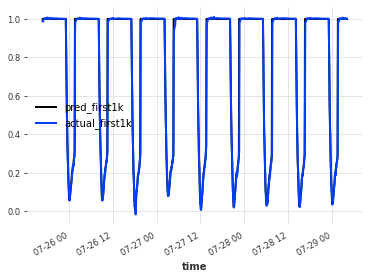

mape     smape       mae  r2_value
226003074  9.873488e-03  0.009896  0.007653  0.991798
226002307  1.312118e-02  0.012941  0.008134  0.919673
226002148  1.715019e+11  0.046310  0.010685  0.981011
226002627  2.528736e-02  0.024979  0.006179  0.993085
226000198  1.611012e-02  0.015804  0.006992  0.996493
226003330  2.829365e-02  0.028482  0.008410  0.991177
226003080  1.165693e-02  0.011776  0.009233  0.993930
226000297  1.958376e-02  0.019099  0.005612  0.998281
226002603  7.550203e+11  0.043779  0.024703  0.717686
226002861  1.701329e-02  0.017686  0.004712  0.996797
226002416  1.233409e-02  0.012430  0.007213  0.995356
226003316  2.774978e-02  0.029071  0.011811  0.979194
226001846  8.143799e+10  0.039405  0.007538  0.996211
226002998  6.606372e+10  0.020469  0.011450  0.921228
226001947  9.432390e-03  0.009483  0.008325  0.953959
226000188  2.990684e-02  0.033821  0.011393  0.983508
226002142  3.668436e-02  0.034837  0.008562  0.987098

In [67]:
results_for_17_test, true_17_test, predict_17 = score_model_darts(model=model_all_pumps, 
                        validation_target=val_target_v3,
                        validation_cov=val_cov_v3,
                        pump_names=get_pump_names(ohe_df))
results_for_17_test

In [68]:
results_for_17_test.to_csv('test_results.csv') 

In [69]:
results_for_17_test.mean()

mape        6.317787e+10
smape       2.413341e-02
mae         9.329768e-03
r2_value    9.644992e-01
dtype: float64

In [70]:
test_tcn = {'test':{'true':true_17_test, 
                      'prediction':predict_17}}

In [71]:
from utils import score_model

In [72]:
test_results = score_model(test_tcn)
test_results

mape     smape      mae  r2_value
test  6.317787e+10  0.024133  0.00933  0.983724

loading validation dataset

In [73]:

def get_one_pump_ext_val(inp_df):
  onehot_series_0 = TimeSeries.from_dataframe(inp_df, 'DT', fill_missing_dates=True, freq='5T')

  scaler = Scaler()
  ts = scaler.fit_transform(onehot_series_0)  # scale the whole time series not caring about train/val split...
  filler = MissingValuesFiller()
  ts = filler.transform(ts, method='linear')
  target = ts['DSHORTT1138P2300058']
  # Create training and validation sets:

  covariates = ts[['T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
        'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
        'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
        'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
        'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399']]

  print(len(covariates), len(target))
  return covariates, target

def get_all_pump_ext_val(df_all_pumps):
  val_cov_all, val_target_all = [], []
  for pump_df in df_all_pumps:
    iter_val, iter_val_target = get_one_pump_ext_val(pump_df)
    val_cov_all.append(iter_val)
    val_target_all.append(iter_val_target)
  return val_cov_all, val_target_all


def read_valid(link, encoder):

    data = pd.read_csv(link, index_col=False)
    data.drop(['Unnamed: 0',
     'MIDUPT1138P2300058',
     'SHORTUPT1138P2300058',
     'LONGUPT1138P2300058',
     'DMIDT1138P2300058',
     'DLONGT1138P2300058',
     'UNIXDT', 'UUID'
     ], axis=1, inplace=True)
    data = data.fillna(0)
    
    transformed = encoder.transform(data.WELL_ID)
    ohe_df = pd.DataFrame(transformed)
    ohe_df.columns = encoder.classes_
    df_oh = pd.concat([data, ohe_df], axis=1).drop(['WELL_ID'], axis=1)

    pump_ids = set(data.WELL_ID.unique())


    df_list = list()

    for pump in pump_ids:
        df_list.append(df_oh[df_oh[pump] == 1])

    val_cov, val_target = get_all_pump_ext_val(df_list)

    return val_target, val_cov, pump_ids

In [74]:
valid1 = 'data/cfp_dataset_v1_valid1.csv'
valid2 = 'data/cfp_dataset_v1_valid2.csv'

In [75]:
val_target1, val_cov1, val1_pumps  = read_valid(valid1, pump_encoder)
val_target2, val_cov2, val2_pumps  = read_valid(valid2, pump_encoder)

1667 1667
963 963
1667 1667
1667 1667
1667 1667
963 963
1667 1667
1667 1667
1667 1667
1667 1667
1667 1667
1263 1263
1667 1667
1667 1667
1667 1667
1667 1667
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334


## запустим более подробно с графиками

In [76]:
def validate_model(model, validation_target, validation_cov):
    results = pd.DataFrame(columns=['mape', 'smape', 'mae', 'r2_value'])
    true_values = []
    predict_values = []
    for part in range(len(validation_target)):
        print(len(validation_target[part]), len(validation_cov[part]))
        backtest_model_all_pumps_iter = model.historical_forecasts(
            series=validation_target[part],
            past_covariates=validation_cov[part],
            start=0.4,
            retrain=False,
            verbose=True)

        backtest_v3 = validation_target[part]
        val_v3pumptarget_inters = backtest_v3.slice_intersect(backtest_model_all_pumps_iter)

        

        y_true = val_v3pumptarget_inters.values()
        y_pred = backtest_model_all_pumps_iter.values()

        true_values.append(y_true)
        predict_values.append(y_pred)


        mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
        smape_v = smape(y_true, y_pred)
        mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
        r2_value = r2_score(y_true=y_true, y_pred=y_pred)

        this_key_df = pd.DataFrame({'mape': mape, 'smape': smape_v, 'mae': mae, 'r2_value': r2_value}, index=[part])
        results = results.append(this_key_df)

        val_v3pumptarget_inters[-100:].plot(label='pred')
        backtest_model_all_pumps_iter[-100:].plot(label='actual')
        plt.show()
        val_v3pumptarget_inters[:1000].plot(label='pred_first1k')
        backtest_model_all_pumps_iter[:1000].plot(label='actual_first1k')
        plt.show()

    true_values = np.concatenate(true_values)
    predict_values = np.concatenate(predict_values)
    return results, true_values, predict_values


1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 122.40it/s]


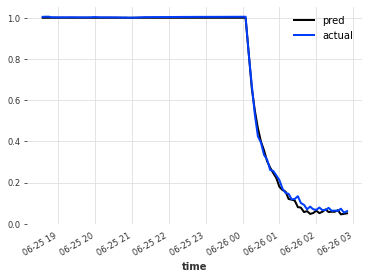

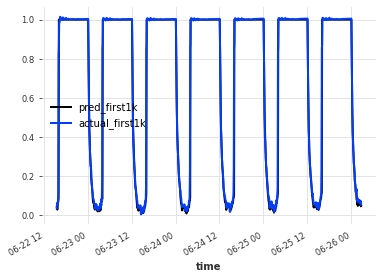

963 963


100%|██████████| 579/579 [00:04<00:00, 121.66it/s]


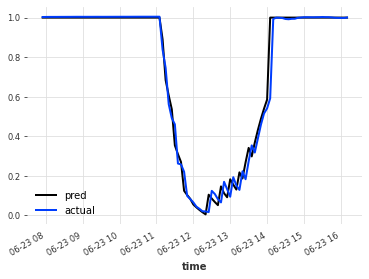

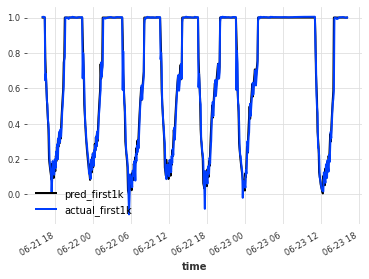

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 122.39it/s]


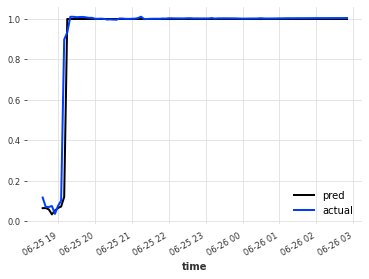

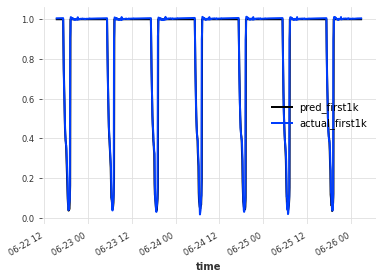

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 119.98it/s]


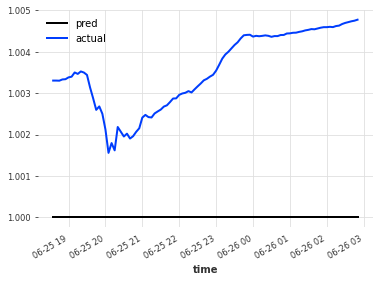

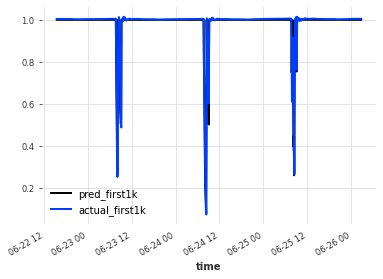

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 120.26it/s]


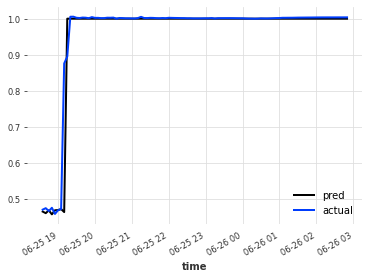

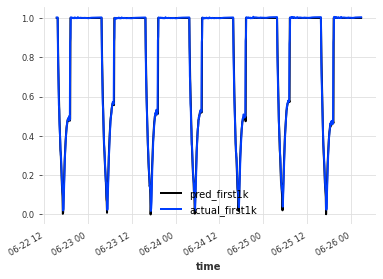

963 963


100%|██████████| 579/579 [00:04<00:00, 121.55it/s]


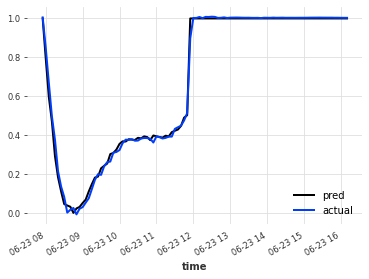

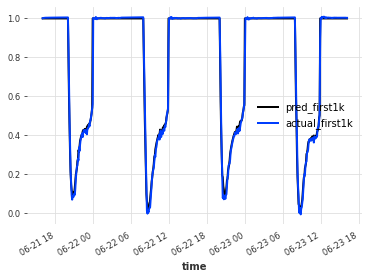

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 118.67it/s]


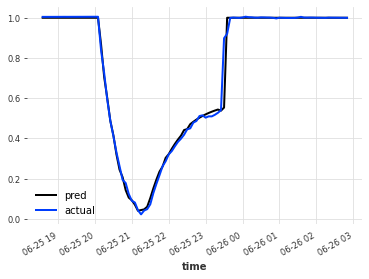

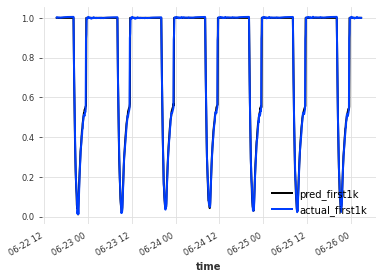

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 120.68it/s]


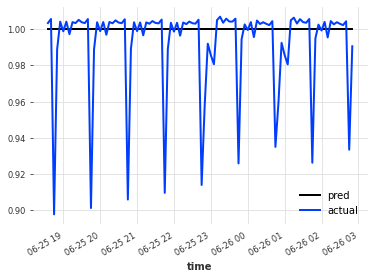

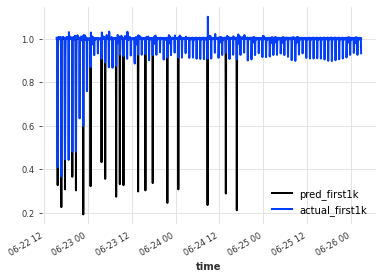

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 120.39it/s]


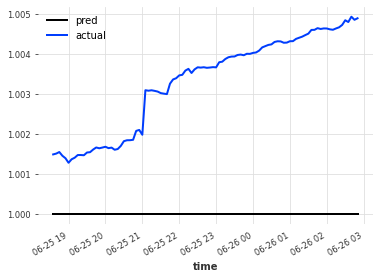

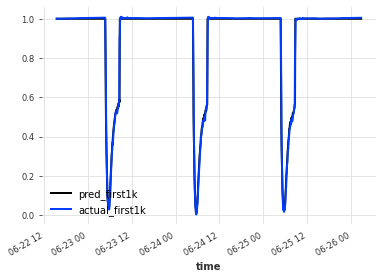

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 119.18it/s]


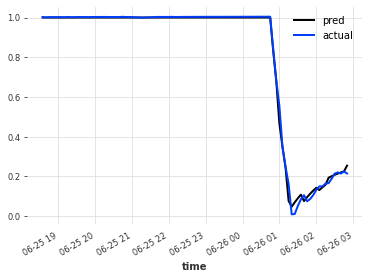

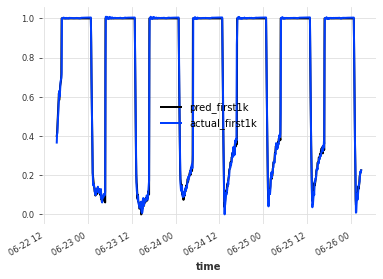

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 118.53it/s]


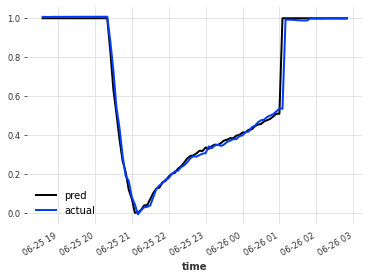

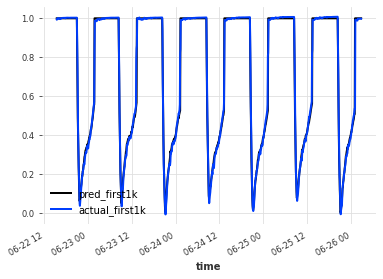

1263 1263


100%|██████████| 759/759 [00:06<00:00, 119.71it/s]


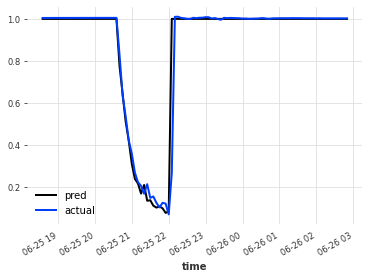

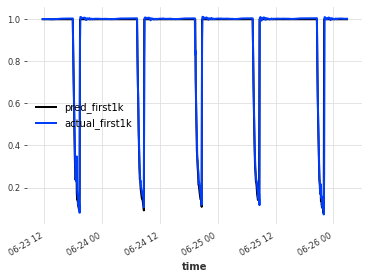

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 118.47it/s]


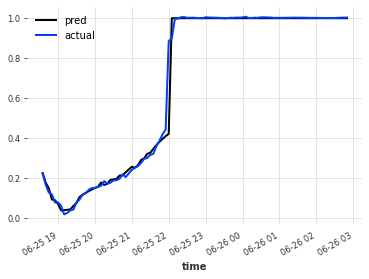

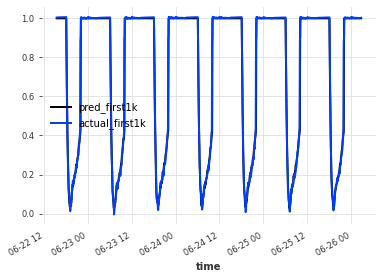

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 117.49it/s]


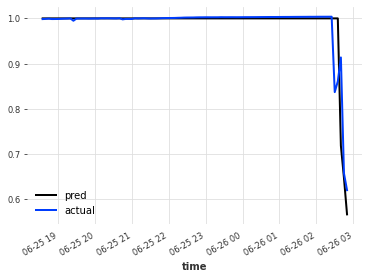

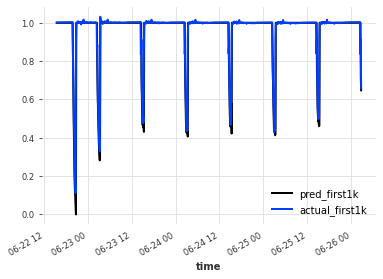

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 115.74it/s]


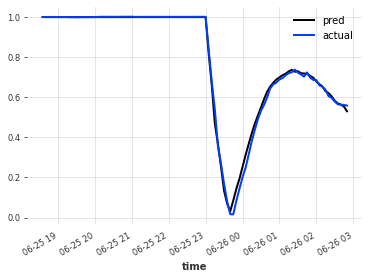

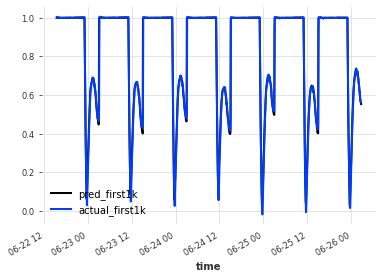

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 116.05it/s]


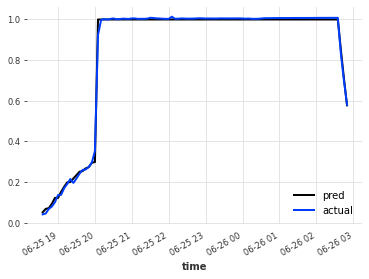

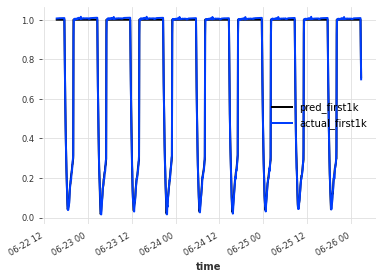

In [77]:
results_for_valid1, true_valid1, predict__valid1 = validate_model(model=model_all_pumps, 
                        validation_target=val_target1,
                        validation_cov=val_cov1)

1334 1334


100%|██████████| 801/801 [00:06<00:00, 120.77it/s]


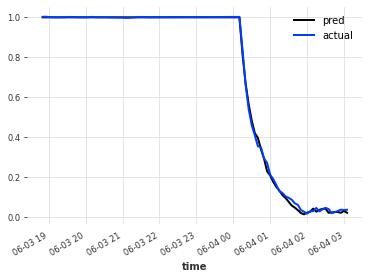

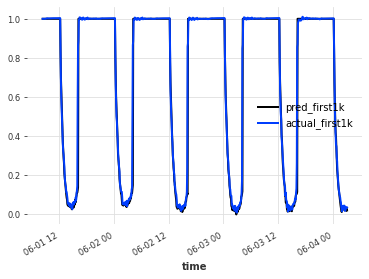

1334 1334


100%|██████████| 801/801 [00:06<00:00, 122.60it/s]


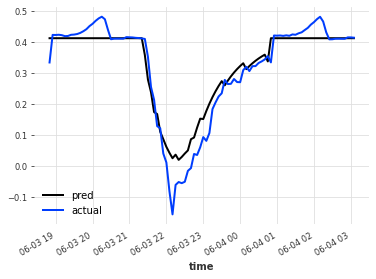

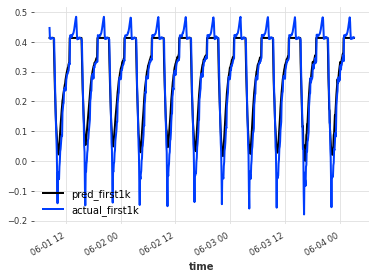

1334 1334


100%|██████████| 801/801 [00:06<00:00, 121.44it/s]


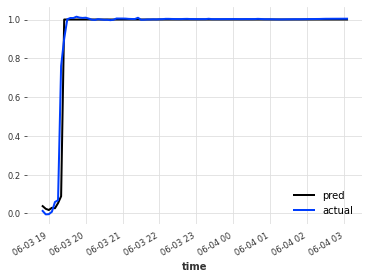

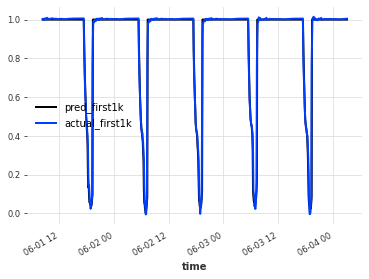

1334 1334


100%|██████████| 801/801 [00:06<00:00, 121.89it/s]


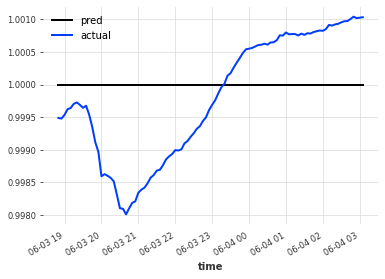

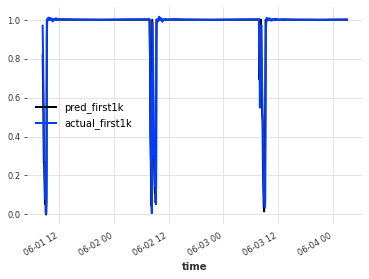

1334 1334


100%|██████████| 801/801 [00:06<00:00, 123.18it/s]


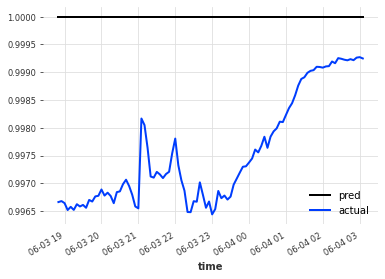

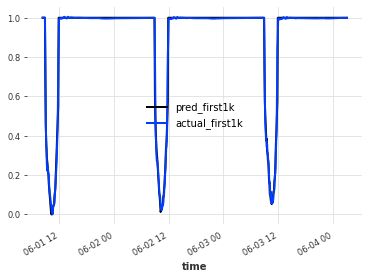

1334 1334


100%|██████████| 801/801 [00:06<00:00, 120.89it/s]


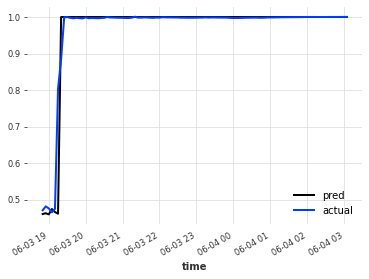

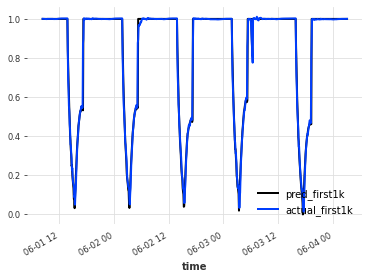

1334 1334


100%|██████████| 801/801 [00:06<00:00, 118.60it/s]


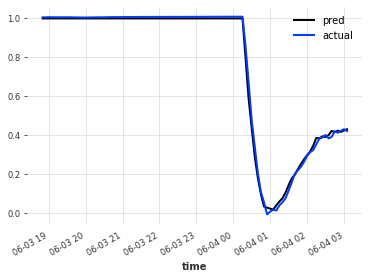

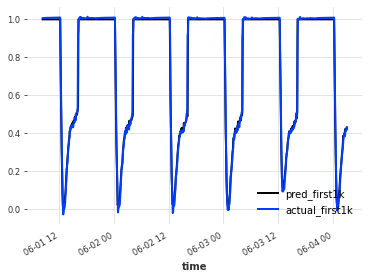

1334 1334


100%|██████████| 801/801 [00:06<00:00, 120.90it/s]


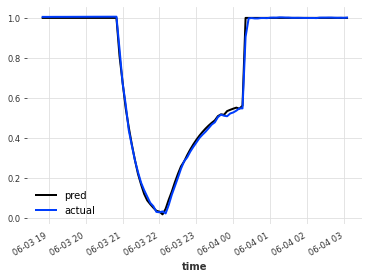

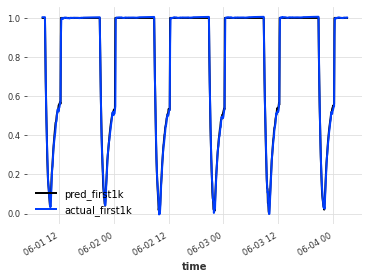

1334 1334


100%|██████████| 801/801 [00:06<00:00, 119.30it/s]


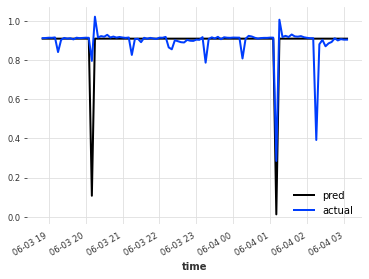

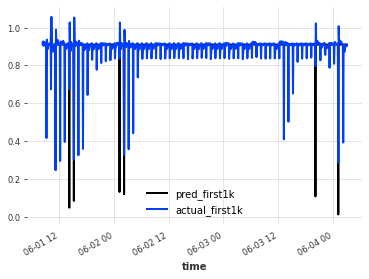

1334 1334


100%|██████████| 801/801 [00:06<00:00, 119.59it/s]


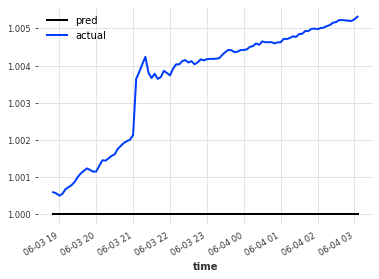

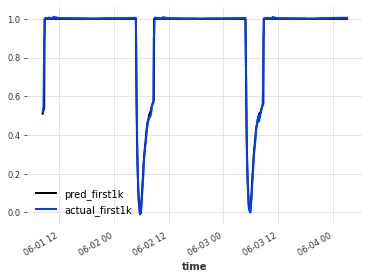

1334 1334


100%|██████████| 801/801 [00:06<00:00, 120.08it/s]


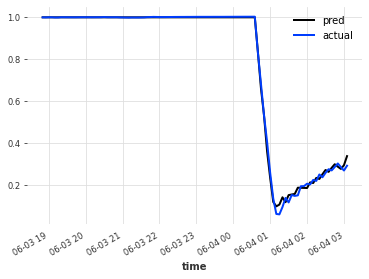

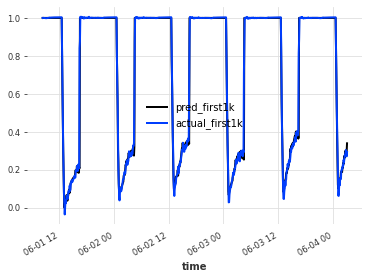

1334 1334


100%|██████████| 801/801 [00:06<00:00, 118.89it/s]


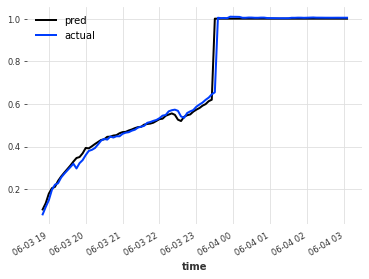

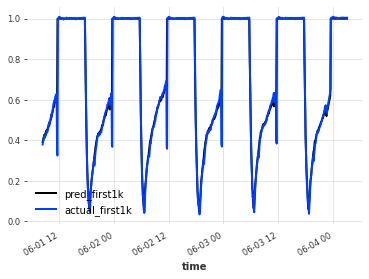

1334 1334


100%|██████████| 801/801 [00:06<00:00, 117.91it/s]


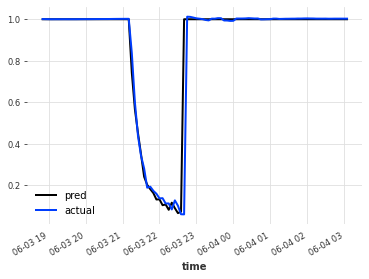

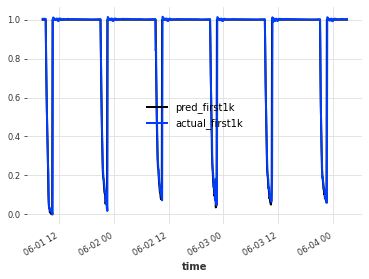

1334 1334


100%|██████████| 801/801 [00:06<00:00, 118.49it/s]


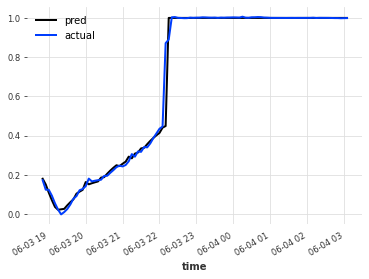

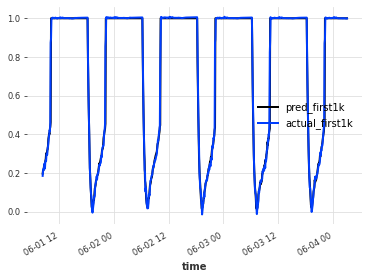

1334 1334


100%|██████████| 801/801 [00:06<00:00, 119.63it/s]


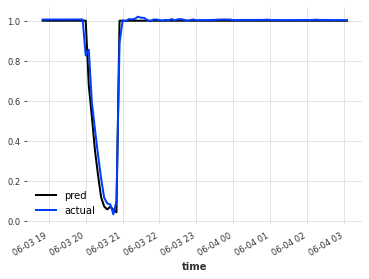

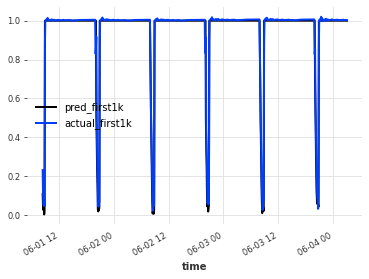

1334 1334


100%|██████████| 801/801 [00:06<00:00, 118.22it/s]


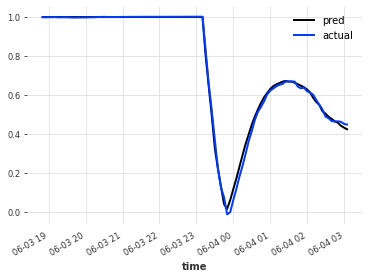

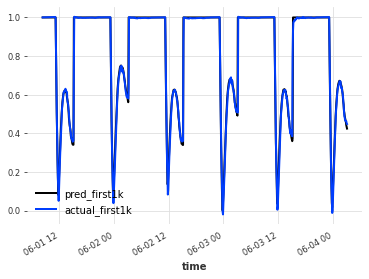

1334 1334


100%|██████████| 801/801 [00:06<00:00, 117.51it/s]


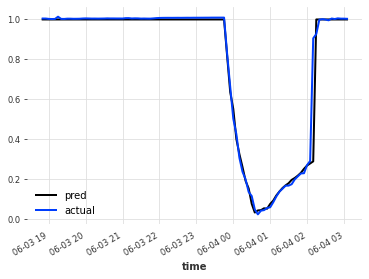

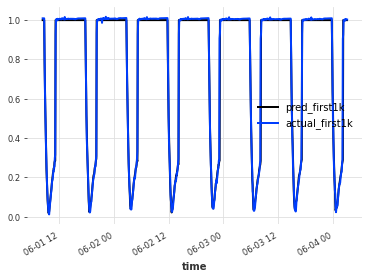

In [78]:
results_for_valid2, true_valid2, predict__valid2 = validate_model(model=model_all_pumps, 
                        validation_target=val_target2,
                        validation_cov=val_cov2)

In [79]:
valid_tcn = {'Valid1':{'true':true_valid1, 
                      'prediction':predict__valid1}, 
             'Valid2':{'true':true_valid2, 
                      'prediction':predict__valid2}}

In [80]:
validtcn_results = score_model(valid_tcn)
validtcn_results.loc['mean_tcn_valid'] = validtcn_results.mean()

validtcn_results.to_csv('tcn_valid_results.csv') 
validtcn_results

mape     smape       mae  r2_value
Valid1          3.705971e+11  0.040466  0.011327  0.978479
Valid2          7.730537e+10  0.062738  0.012757  0.978367
mean_tcn_valid  2.239512e+11  0.051602  0.012042  0.978423

# transformers

In [81]:
from darts.models import TransformerModel


In [82]:
trans_model = TransformerModel(
    input_chunk_length = 10,
    output_chunk_length = 1,
    batch_size = 32,
    n_epochs = EPOCH,
    model_name = 'all_pumps_transformer',
    log_tensorboard=True,
    nr_epochs_val_period = 10,
    d_model = 32,
    nhead = 16,
    num_encoder_layers = 3,
    num_decoder_layers = 3,
    dim_feedforward = 512,
    dropout = 0.1,
    activation = "relu",
    random_state=0
)

In [83]:
trans_model.fit(series=train_target_v3,
              past_covariates=train_cov_v3,
              val_series=val_target_v3,
              val_past_covariates=val_cov_v3,
              verbose=True)

  1%|          | 1/100 [02:21<3:54:00, 141.82s/it]

 11%|█         | 11/100 [23:41<3:14:51, 131.36s/it]

 21%|██        | 21/100 [45:02<2:53:16, 131.60s/it]

 31%|███       | 31/100 [1:06:25<2:31:31, 131.76s/it]

 41%|████      | 41/100 [1:27:44<2:08:51, 131.04s/it]

 51%|█████     | 51/100 [1:49:05<1:47:16, 131.36s/it]

 61%|██████    | 61/100 [2:10:28<1:25:39, 131.79s/it]

 71%|███████   | 71/100 [2:31:55<1:03:38, 131.68s/it]

 81%|████████  | 81/100 [2:53:15<41:36, 131.39s/it]

 91%|█████████ | 91/100 [3:14:35<19:38, 130.94s/it]

100%|██████████| 100/100 [3:33:30<00:00, 128.11s/it]


In [84]:
trans_model.save_model('allpumps_transformer.pth.tar')

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 96.30it/s]


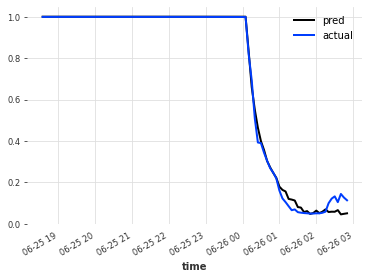

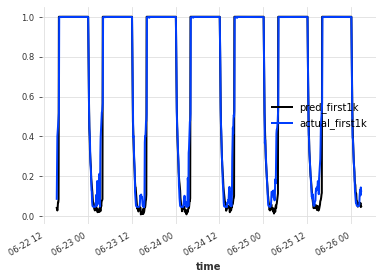

963 963


100%|██████████| 579/579 [00:05<00:00, 98.52it/s]


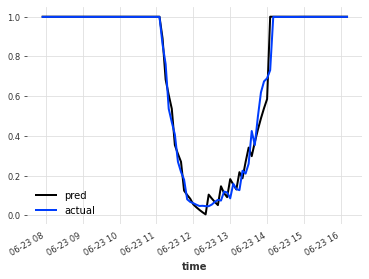

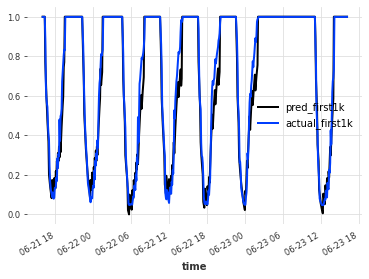

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 96.62it/s]


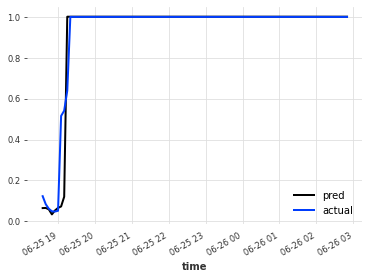

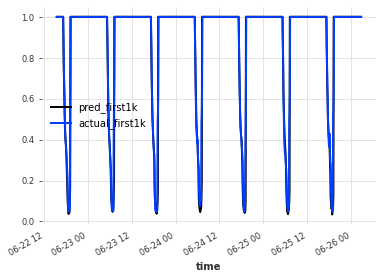

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 97.69it/s]


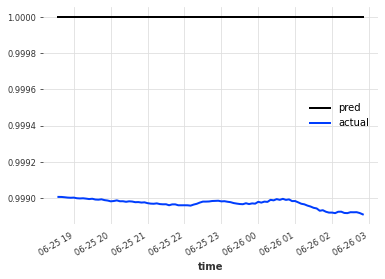

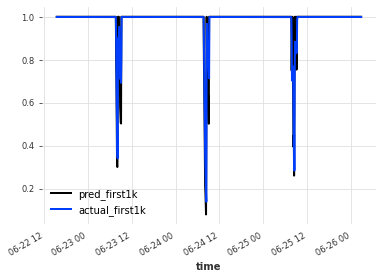

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 97.82it/s]


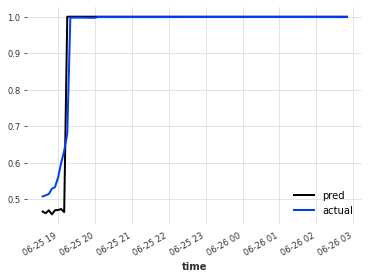

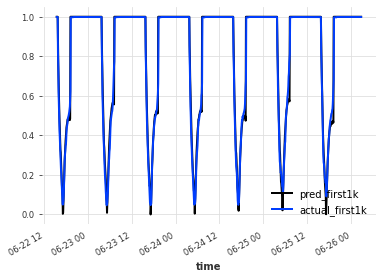

963 963


100%|██████████| 579/579 [00:06<00:00, 96.49it/s]


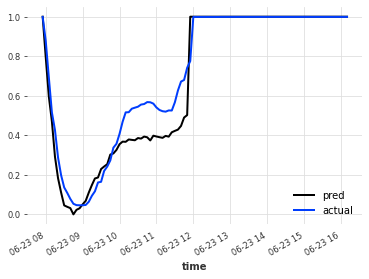

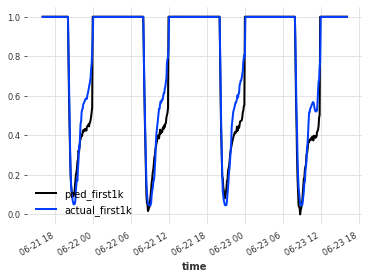

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 96.24it/s]


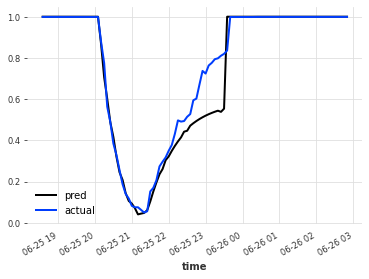

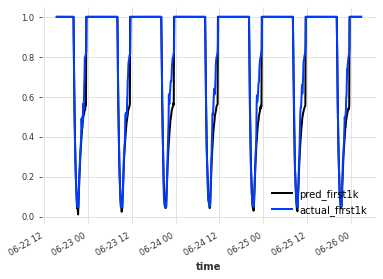

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 95.66it/s]


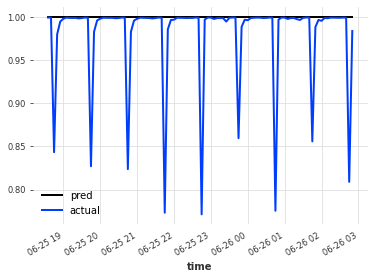

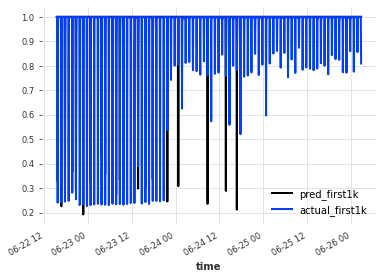

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 95.27it/s]


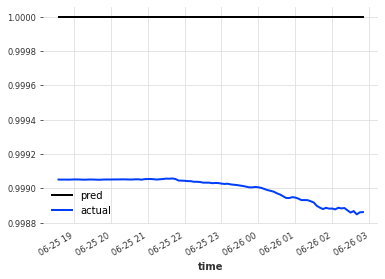

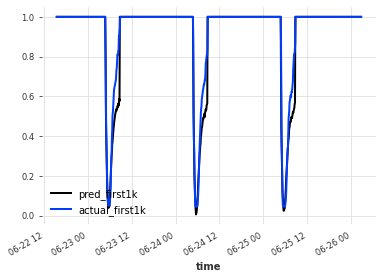

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 93.40it/s]


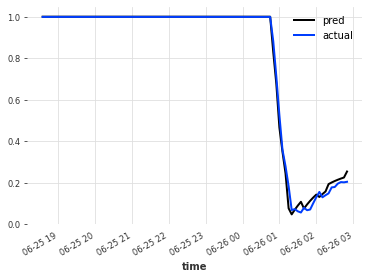

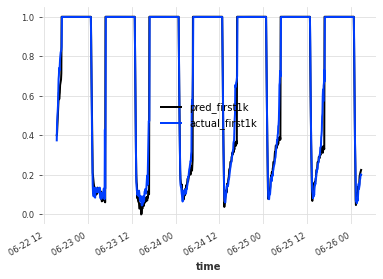

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 94.99it/s]


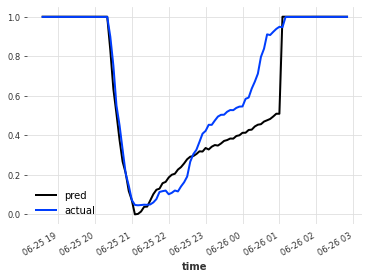

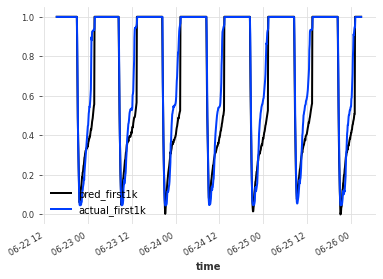

1263 1263


100%|██████████| 759/759 [00:08<00:00, 94.13it/s]


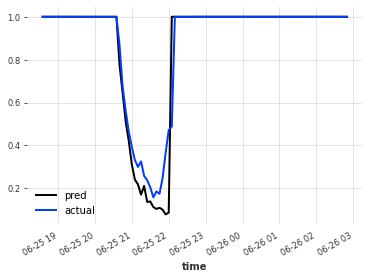

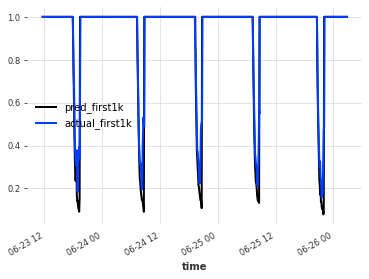

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 93.87it/s]


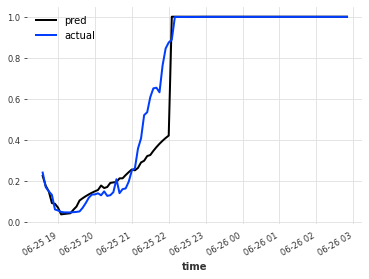

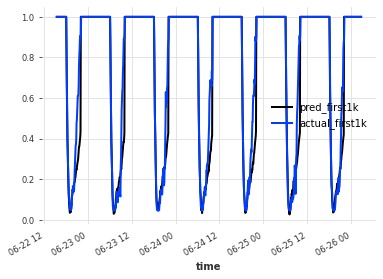

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 94.02it/s]


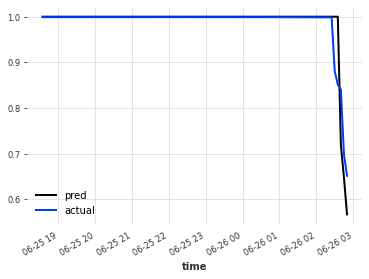

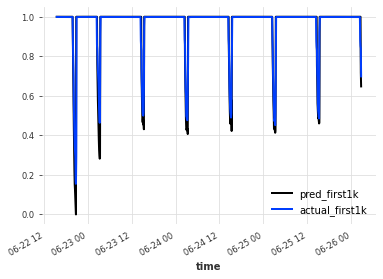

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 94.08it/s]


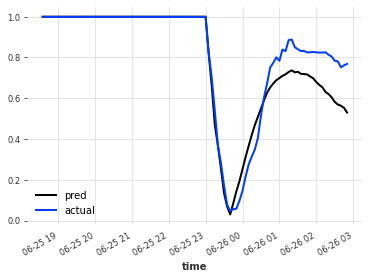

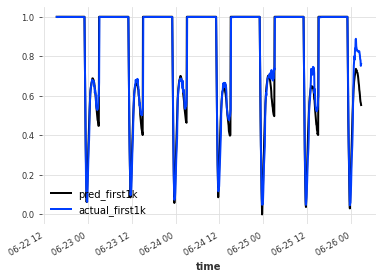

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 93.80it/s]


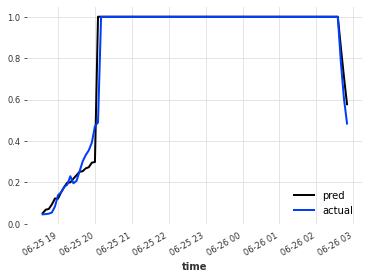

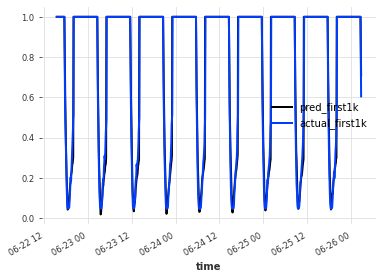

In [85]:
results_for_valid1trans, true_valid1trans, predict__valid1trans = validate_model(model=trans_model, 
                        validation_target=val_target1,
                        validation_cov=val_cov1)

1334 1334


100%|██████████| 801/801 [00:08<00:00, 97.59it/s] 


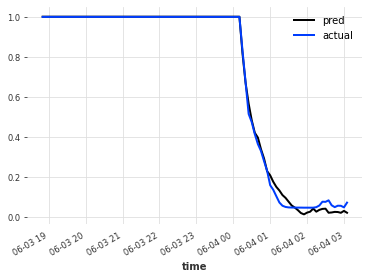

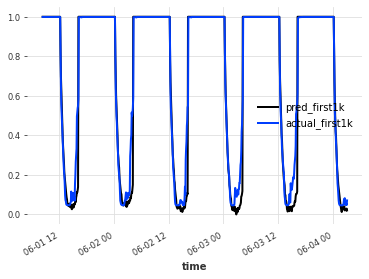

1334 1334


100%|██████████| 801/801 [00:08<00:00, 97.31it/s]


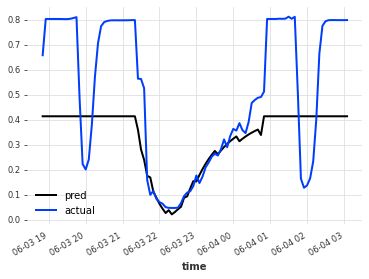

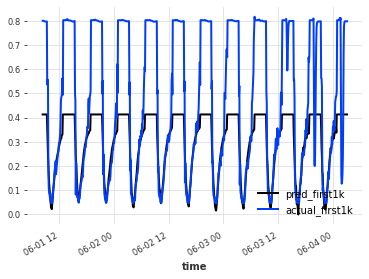

1334 1334


100%|██████████| 801/801 [00:08<00:00, 97.95it/s]


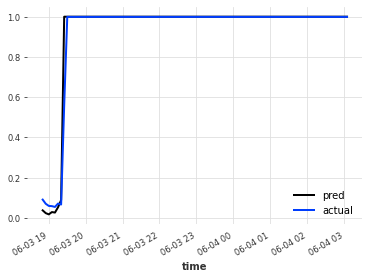

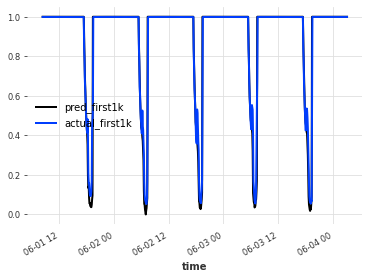

1334 1334


100%|██████████| 801/801 [00:08<00:00, 98.11it/s]


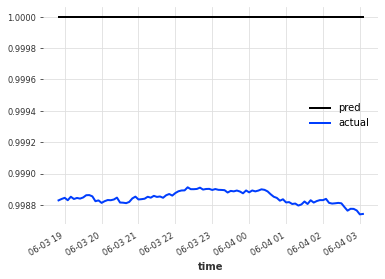

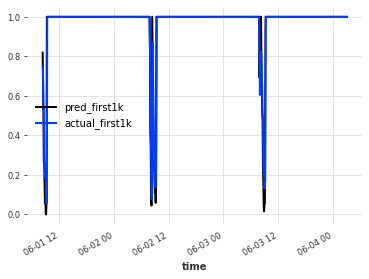

1334 1334


100%|██████████| 801/801 [00:08<00:00, 96.64it/s]


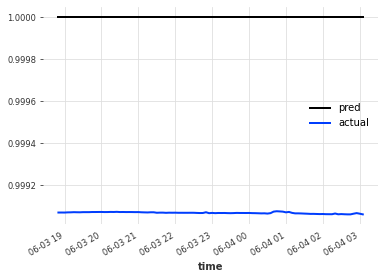

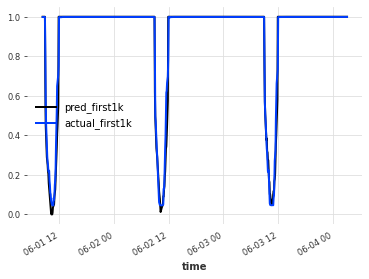

1334 1334


100%|██████████| 801/801 [00:08<00:00, 97.10it/s]


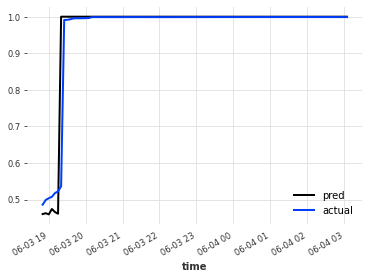

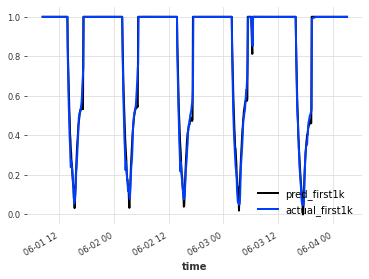

1334 1334


100%|██████████| 801/801 [00:08<00:00, 95.01it/s]


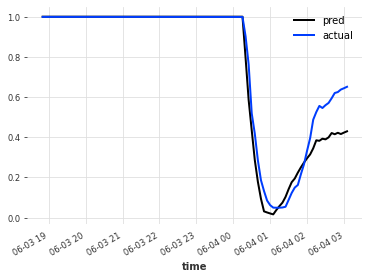

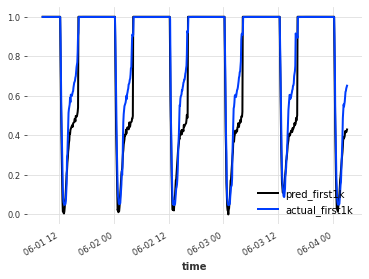

1334 1334


100%|██████████| 801/801 [00:08<00:00, 96.11it/s]


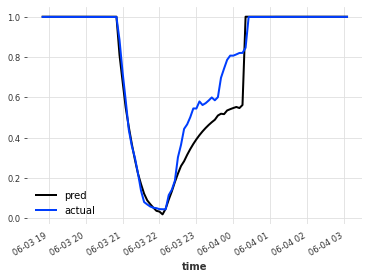

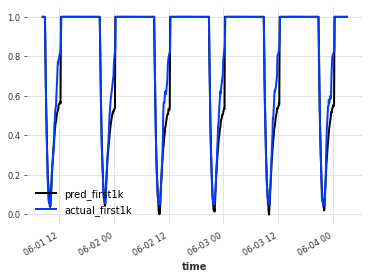

1334 1334


100%|██████████| 801/801 [00:08<00:00, 94.71it/s]


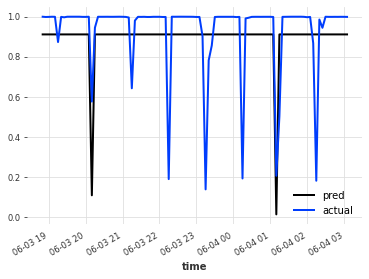

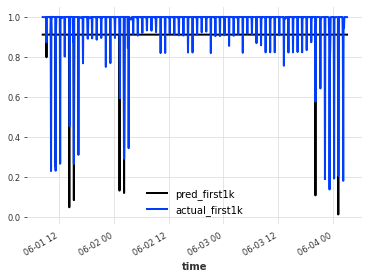

1334 1334


100%|██████████| 801/801 [00:08<00:00, 95.17it/s]


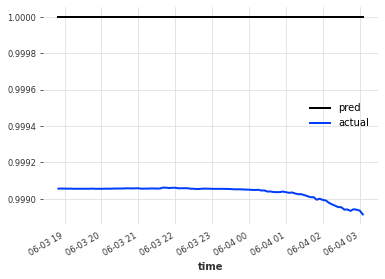

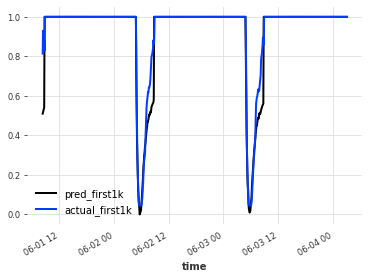

1334 1334


100%|██████████| 801/801 [00:08<00:00, 92.57it/s]


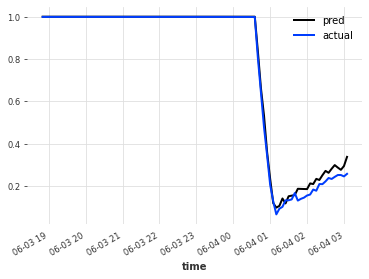

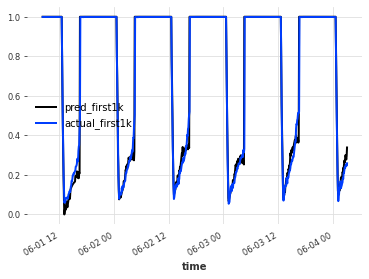

1334 1334


100%|██████████| 801/801 [00:08<00:00, 94.14it/s]


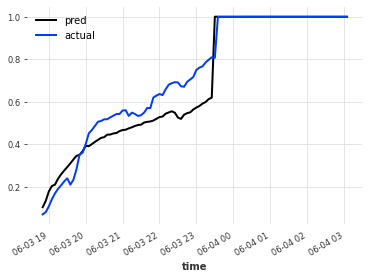

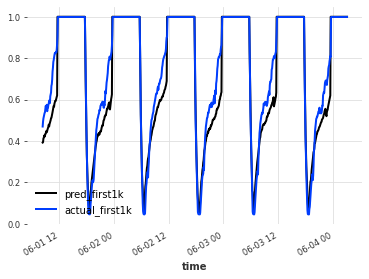

1334 1334


100%|██████████| 801/801 [00:08<00:00, 94.45it/s]


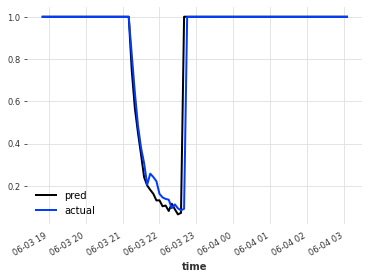

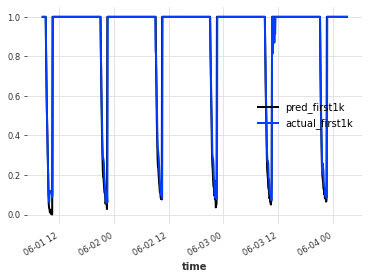

1334 1334


100%|██████████| 801/801 [00:08<00:00, 93.90it/s]


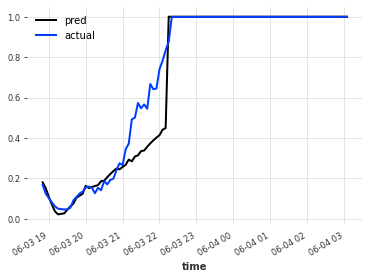

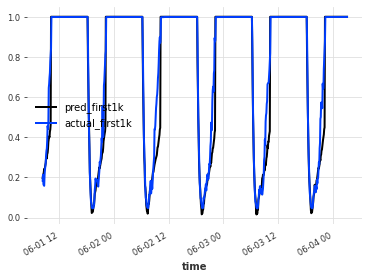

1334 1334


100%|██████████| 801/801 [00:08<00:00, 93.36it/s]


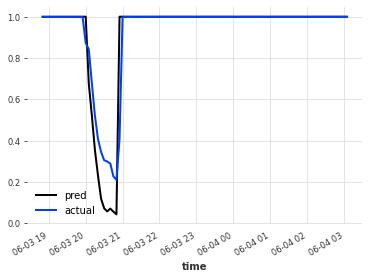

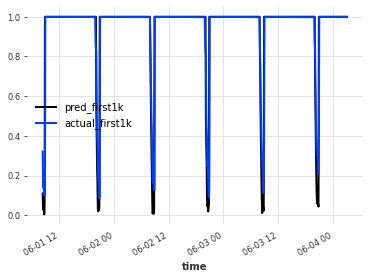

1334 1334


100%|██████████| 801/801 [00:08<00:00, 94.25it/s]


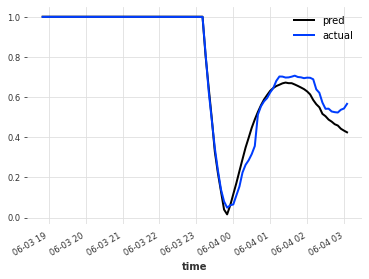

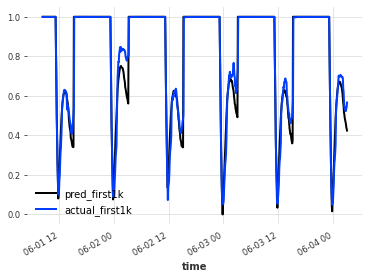

1334 1334


100%|██████████| 801/801 [00:08<00:00, 93.52it/s]


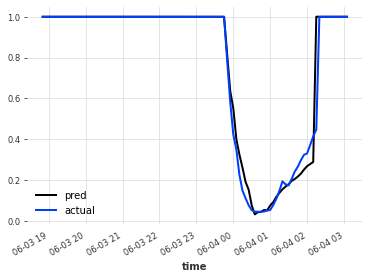

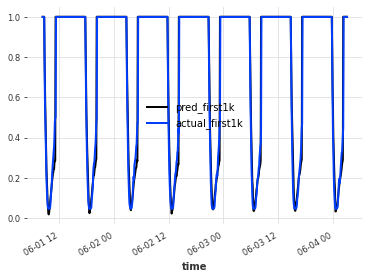

In [86]:
results_for_valid2trans, true_valid2trans, predict__valid2trans = validate_model(model=trans_model, 
                        validation_target=val_target2,
                        validation_cov=val_cov2)

In [87]:
valid_trans = {'Valid1':{'true':true_valid1trans, 
                      'prediction':predict__valid1trans}, 
             'Valid2':{'true':true_valid2trans, 
                      'prediction':predict__valid2trans}}

In [88]:
validtrans_results = score_model(valid_trans)
validtrans_results.loc['mean_transformers_valid'] = validtrans_results.mean()

validtrans_results.to_csv('transformers_valid_results.csv') 
validtrans_results

mape     smape       mae  r2_value
Valid1                   1.444587e+11  0.075743  0.024318  0.941862
Valid2                   2.157654e+11  0.100397  0.037189  0.913306
mean_transformers_valid  1.801120e+11  0.088070  0.030753  0.927584